(lc-multi)=

# Light curves from multiple instruments

In [1]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.4.dev12+g049d30a'


In the {ref}`rv-multi` case study, we discussed fitting the radial velocity curve for a planetary system observed using multiple instruments.
You might also want to fit data from multiple instruments when fitting the light curve of a transiting planet and that's what we work through in this example.
This is a somewhat more complicated example than the radial velocity case because some of the physical properties of the system can vary as as function of the instrument.
Specifically, the transit depth (or the effective radius of the planet) will be a function of the filter or effective wavelength of the observations.
This is the idea behind transit spectroscopy and the method used in this case study could (and should!) be extended to that use case.
In this case, we'll combine the light curves from the Kepler and TESS missions for the planet host HAT-P-11.

## A brief aside on dataset "weighting"

Before getting into the details of this case study, let's spend a minute talking about a topic that comes up a lot when discussing combining observations from different instruments or techniques.
To many people, it seems intuitive that one should (and perhaps must) "weight" how much each dataset contributes to the likelihood based on how much they "trust" those data.
For example, you might be worried that a dataset with more datapoints will have a larger effect on the the results than you would like.
While this might seem intuitive, it's wrong: **the only way to combine datasets is to multiply their likelihood functions**.
Instead, it is useful to understand what you actually mean when you say that you don't "trust" a dataset as much as another.
**What you're really saying is that you don't believe the observation model that you wrote down**.
For example, you might think that the quoted error bars are underestimated or there might be correlated noise that an uncorrelated normal observation model can't capture.
The benefit of thinking about it this way is that it suggests a solution to the problem: incorporate a more flexible observation model that can capture these issues.
In this case study, the 4 years of (long-cadence) Kepler observations only include about two times as many data points as one month of TESS observations.
But, as you can see in the figure below, these two datasets have different noise properties (both in terms of photon noise and correlated noise) so we will fit using a different flexible Gaussian process noise model for each data set that will take these different properties into account.

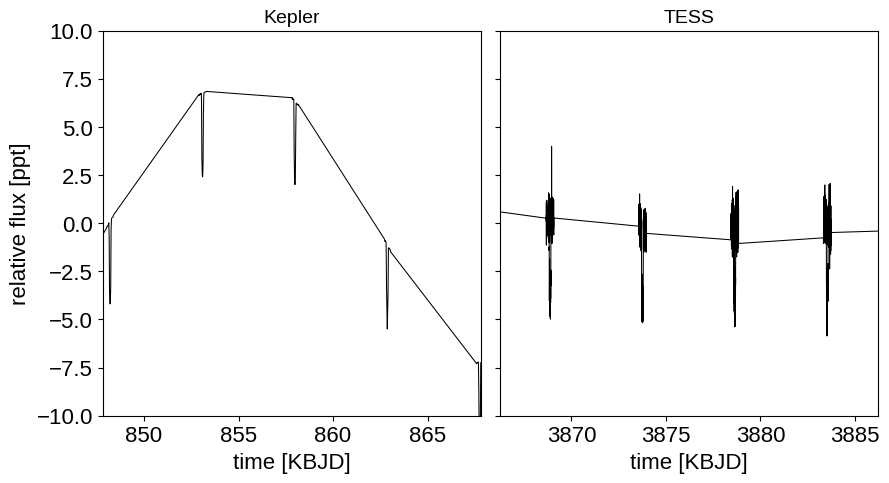

In [2]:
import numpy as np
import lightkurve as lk
from astropy.io import fits
from collections import OrderedDict
import matplotlib.pyplot as plt

# Period and reference transit time from the literature for initialization
lit_period = 4.887803076
lit_t0 = 124.8130808


def transit_mask(t):
    return (
        np.abs((t - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period)
        < 0.2
    )


kepler_lcfs = lk.search_lightcurve(
    "HAT-P-11", mission="Kepler", cadence="long"
).download_all(flux_column="pdcsap_flux")
kepler_lc = kepler_lcfs.stitch().remove_nans()

# For the purposes of this example, let's only clip out data near the transits
m = transit_mask(kepler_lc.time.value)
kepler_t = np.ascontiguousarray(kepler_lc.time.value[m], dtype=np.float64)
kepler_y = np.ascontiguousarray(
    1e3 * (kepler_lc.flux[m] - 1), dtype=np.float64
)
kepler_yerr = np.ascontiguousarray(
    1e3 * kepler_lc.flux_err[m], dtype=np.float64
)

with fits.open(kepler_lcfs[0].filename) as hdu:
    hdr = hdu[1].header
kepler_texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
kepler_texp /= 60.0 * 60.0 * 24.0

tess_lcfs = lk.search_lightcurve(
    "HAT-P-11", mission="TESS", author="SPOC", sector=(14, 15)
).download_all(flux_column="pdcsap_flux")
tess_lc = tess_lcfs.stitch().remove_nans()

# For the purposes of this example, let's only clip out data near the transits
t = tess_lc.time.value + 2457000 - 2454833
m = transit_mask(t)
tess_t = np.ascontiguousarray(t[m], dtype=np.float64)
tess_y = np.ascontiguousarray(1e3 * (tess_lc.flux[m] - 1), dtype=np.float64)
tess_yerr = np.ascontiguousarray(1e3 * tess_lc.flux_err[m], dtype=np.float64)

with fits.open(tess_lcfs[0].filename) as hdu:
    hdr = hdu[1].header
tess_texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
tess_texp /= 60.0 * 60.0 * 24.0

datasets = OrderedDict(
    [
        ("Kepler", [kepler_t, kepler_y, kepler_yerr, kepler_texp]),
        ("TESS", [tess_t, tess_y, tess_yerr, tess_texp]),
    ]
)

fig, axes = plt.subplots(1, len(datasets), sharey=True, figsize=(10, 5))

for i, (name, (t, y, _, _)) in enumerate(datasets.items()):
    ax = axes[i]
    ax.plot(t, y, "k", lw=0.75, label=name)
    ax.set_xlabel("time [KBJD]")
    ax.set_title(name, fontsize=14)

    x_mid = 0.5 * (t.min() + t.max())
    ax.set_xlim(x_mid - 10, x_mid + 10)
axes[0].set_ylim(-10, 10)
fig.subplots_adjust(wspace=0.05)
_ = axes[0].set_ylabel("relative flux [ppt]")

## The probabilistic model

This model is mostly the same as the one used in [Quick fits for TESS light curves](./quick-tess.ipynb), but we're allowing for different noise variances (both the white noise component and the GP amplitude), effective planet radii, and limb-darkening coefficients for each dataset.
For the purposes of demonstration, we're sharing the length scale of the GP between the two datasets, but this could just have well been a different parameter for each dataset without changing the results.
The final change that we're using is to use the approximate transit depth `approx_depth` (the depth of the transit at minimum assuming the limb-darkening profile is constant under the disk of the planet) as a parameter instead of the radius ratio.
This does not have a large effect on the performance or the results, but it can sometimes be a useful parameterization when dealing with high signal-to-noise transits because it reduces the covariance between the radius parameter and the limb darkening coefficients.
As usual, we run a few iterations of sigma clipping and then find the maximum a posteriori parameters to check to make sure that everything is working:

In [3]:
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import aesara_theano_fallback.tensor as tt
from functools import partial
from celerite2.theano import terms, GaussianProcess

# Find a reference transit time near the middle of the observations to avoid
# strong covariances between period and t0
x_min = min(np.min(x) for x, _, _, _ in datasets.values())
x_max = max(np.max(x) for x, _, _, _ in datasets.values())
x_mid = 0.5 * (x_min + x_max)
t0_ref = lit_t0 + lit_period * np.round((x_mid - lit_t0) / lit_period)

# Do several rounds of sigma clipping
for i in range(10):
    with pm.Model() as model:

        # Shared orbital parameters
        log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=1.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=t0_ref, sigma=1.0)
        log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
        dur = pm.Deterministic("dur", tt.exp(log_dur))
        b = pmx.UnitUniform("b")
        ld_arg = 1 - tt.sqrt(1 - b**2)
        orbit = xo.orbits.KeplerianOrbit(
            period=period, duration=dur, t0=t0, b=b
        )

        # We'll also say that the timescale of the GP will be shared
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=2.0,
            **pmx.estimate_inverse_gamma_parameters(1.0, 5.0),
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        gp_preds = dict()
        gp_preds_with_mean = dict()
        for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):

            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sigma=10.0)

                # The limb darkening
                u = xo.QuadLimbDark("u")
                star = xo.LimbDarkLightCurve(u)

                # The radius ratio
                log_approx_depth = pm.Normal(
                    "log_approx_depth", mu=np.log(4e-3), sigma=10
                )
                ld = 1 - u[0] * ld_arg - u[1] * ld_arg**2
                ror = pm.Deterministic(
                    "ror", tt.exp(0.5 * log_approx_depth) / tt.sqrt(ld)
                )

                # Noise parameters
                med_yerr = np.median(yerr)
                std = np.std(y)
                sigma = pm.InverseGamma(
                    "sigma",
                    testval=med_yerr,
                    **pmx.estimate_inverse_gamma_parameters(
                        med_yerr, 0.5 * std
                    ),
                )
                sigma_gp = pm.InverseGamma(
                    "sigma_gp",
                    testval=0.5 * std,
                    **pmx.estimate_inverse_gamma_parameters(
                        med_yerr, 0.5 * std
                    ),
                )

                # Keep track of the parameters for optimization
                parameters[name] = [mean, u, log_approx_depth]
                parameters[f"{name}_noise"] = [sigma, sigma_gp]

            # The light curve model
            def lc_model(mean, star, ror, texp, t):
                return mean + 1e3 * tt.sum(
                    star.get_light_curve(orbit=orbit, r=ror, t=t, texp=texp),
                    axis=-1,
                )

            lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model

            # The Gaussian Process noise model
            kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3)
            gp = GaussianProcess(
                kernel, t=x, diag=yerr**2 + sigma**2, mean=lc_model
            )
            gp.marginal(f"{name}_obs", observed=y)
            gp_preds[name] = gp.predict(y, include_mean=False)
            gp_preds_with_mean[name] = gp_preds[name] + gp.mean_value

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[f"{name}_noise"])
            map_soln = pmx.optimize(map_soln, parameters[name] + [log_dur, b])
        map_soln = pmx.optimize(map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = pmx.eval_in_model(gp_preds_with_mean[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")

        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

optimizing logp for variables: [Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -36929.236804140644 -> -7691.628763157473


optimizing logp for variables: [TESS_log_approx_depth, TESS_u, TESS_mean]


message: Optimization terminated successfully.
logp: -7691.628763157473 -> -7487.191192486369


optimizing logp for variables: [Kepler_sigma_gp, Kepler_sigma]


message: Optimization terminated successfully.
logp: -7487.191192486369 -> -2129.572500171135


optimizing logp for variables: [b, log_dur, Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Optimization terminated successfully.
logp: -2129.5725001711444 -> -1214.4800752014235


optimizing logp for variables: [TESS_sigma_gp, TESS_sigma]


message: Optimization terminated successfully.
logp: -1214.480075201419 -> -1183.3252046965367


optimizing logp for variables: [b, log_dur, TESS_log_approx_depth, TESS_u, TESS_mean]


message: Optimization terminated successfully.
logp: -1183.3252046965417 -> -1129.3497082196047


optimizing logp for variables: [TESS_sigma_gp, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, Kepler_sigma_gp, Kepler_sigma, Kepler_log_approx_depth, Kepler_u, Kepler_mean, rho_gp, b, log_dur, t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -1129.3497082196047 -> 450.8327422401326


Sigma clipped 85 Kepler light curve points


Sigma clipped 5 TESS light curve points


optimizing logp for variables: [Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -33780.417853306106 -> -4579.641146271535


optimizing logp for variables: [TESS_log_approx_depth, TESS_u, TESS_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -4579.641146271535 -> -4371.468963666697


optimizing logp for variables: [Kepler_sigma_gp, Kepler_sigma]


message: Optimization terminated successfully.
logp: -4371.468963666697 -> -1578.8758612030995


optimizing logp for variables: [b, log_dur, Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -1578.8758612031027 -> -444.3579525070836


optimizing logp for variables: [TESS_sigma_gp, TESS_sigma]


message: Optimization terminated successfully.
logp: -444.35795250708725 -> -400.476433564595


optimizing logp for variables: [b, log_dur, TESS_log_approx_depth, TESS_u, TESS_mean]


message: Optimization terminated successfully.
logp: -400.4764335645923 -> -344.07798786314197


optimizing logp for variables: [TESS_sigma_gp, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, Kepler_sigma_gp, Kepler_sigma, Kepler_log_approx_depth, Kepler_u, Kepler_mean, rho_gp, b, log_dur, t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -344.0779878631529 -> 1666.232312891008


Sigma clipped 25 Kepler light curve points


Sigma clipped 0 TESS light curve points


optimizing logp for variables: [Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -33497.0890337991 -> -4296.353799183115


optimizing logp for variables: [TESS_log_approx_depth, TESS_u, TESS_mean]


message: Optimization terminated successfully.
logp: -4296.353799183115 -> -4088.1816165782943


optimizing logp for variables: [Kepler_sigma_gp, Kepler_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -4088.1816165782943 -> -1533.0518403009899


optimizing logp for variables: [b, log_dur, Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -1533.0518403010067 -> -366.5920777516967


optimizing logp for variables: [TESS_sigma_gp, TESS_sigma]


message: Optimization terminated successfully.
logp: -366.592077751694 -> -322.3472765230081


optimizing logp for variables: [b, log_dur, TESS_log_approx_depth, TESS_u, TESS_mean]


message: Optimization terminated successfully.
logp: -322.34727652301353 -> -268.19623114078604


optimizing logp for variables: [TESS_sigma_gp, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, Kepler_sigma_gp, Kepler_sigma, Kepler_log_approx_depth, Kepler_u, Kepler_mean, rho_gp, b, log_dur, t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -268.19623114078604 -> 1851.8496467680197


Sigma clipped 7 Kepler light curve points


Sigma clipped 0 TESS light curve points


Here are the two phased light curves (with the Gaussian process model removed).
We can see the effect of exposure time integration and the difference in photometric precision, but everything should be looking good!

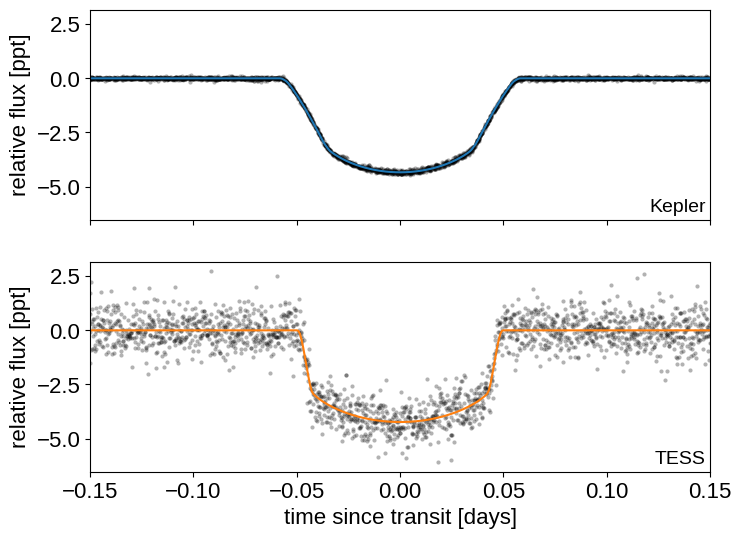

In [4]:
dt = np.linspace(-0.2, 0.2, 500)

with model:
    trends = pmx.eval_in_model([gp_preds[k] for k in datasets], map_soln)
    phase_curves = pmx.eval_in_model(
        [lc_models[k](t0 + dt) for k in datasets], map_soln
    )

fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(8, 6))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y - trends[n] - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(
        dt, phase_curves[n] - map_soln[f"{name}_mean"], f"C{n}", label=name
    )
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

Then we run the MCMC:

In [5]:
import platform

with model:
    trace = pmx.sample(
        tune=1500,
        draws=1500,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=1 if platform.system() == "Darwin" else 2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[11, 9],
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [TESS_sigma_gp, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, Kepler_sigma_gp, Kepler_sigma, Kepler_log_approx_depth, Kepler_u, Kepler_mean, rho_gp, b, log_dur, t0, log_period]


Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 494 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


And check the convergence diagnostics:

In [6]:
import arviz as az

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_period,1.587,0.000,1.587,1.587,0.000,0.000,3945.0,2125.0,1.00
t0,2011.505,0.000,2011.505,2011.505,0.000,0.000,4098.0,2156.0,1.00
log_dur,-2.388,0.002,-2.392,-2.384,0.000,0.000,692.0,855.0,1.00
Kepler_mean,-0.446,0.546,-1.385,0.645,0.009,0.008,3577.0,2272.0,1.00
Kepler_log_approx_depth,-5.684,0.003,-5.689,-5.678,0.000,0.000,1303.0,1025.0,1.00
TESS_mean,0.280,0.406,-0.487,1.046,0.007,0.007,3634.0,1995.0,1.00
TESS_log_approx_depth,-5.668,0.013,-5.691,-5.644,0.000,0.000,2972.0,2343.0,1.00
period,4.888,0.000,4.888,4.888,0.000,0.000,3945.0,2125.0,1.00
dur,0.092,0.000,0.091,0.092,0.000,0.000,692.0,855.0,1.00
b,0.388,0.071,0.260,0.506,0.004,0.003,596.0,332.0,1.00


Since we fit for a radius ratio in each band, we can see if the transit depth is different in Kepler compared to TESS.
The plot below demonstrates that there is no statistically significant difference between the radii measured in these two bands:

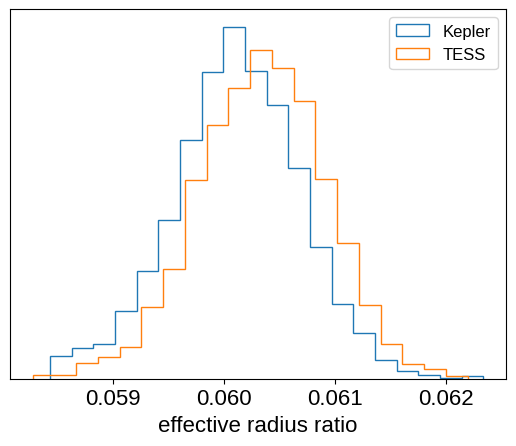

In [7]:
plt.hist(
    trace.posterior["Kepler_ror"].values.flatten(),
    20,
    density=True,
    histtype="step",
    label="Kepler",
)
plt.hist(
    trace.posterior["TESS_ror"].values.flatten(),
    20,
    density=True,
    histtype="step",
    label="TESS",
)
plt.yticks([])
plt.xlabel("effective radius ratio")
_ = plt.legend(fontsize=12)

We can also compare the inferred limb-darkening coefficients:

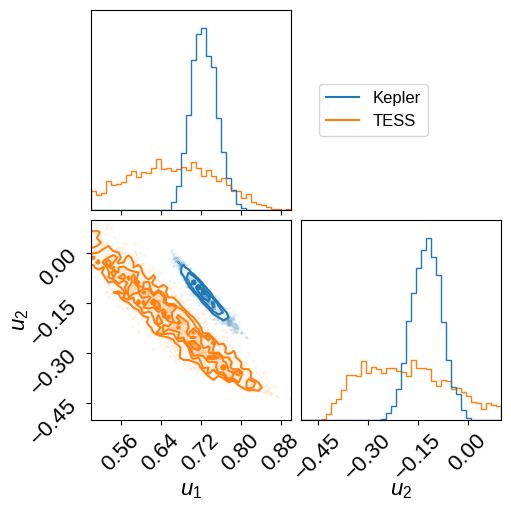

In [8]:
import corner

fig = corner.corner(
    trace,
    var_names=["TESS_u"],
    bins=40,
    color="C1",
    range=((0.5, 0.9), (-0.5, 0.1)),
)
corner.corner(
    trace,
    var_names=["Kepler_u"],
    bins=40,
    color="C0",
    fig=fig,
    labels=["$u_1$", "$u_2$"],
    range=((0.5, 0.9), (-0.5, 0.1)),
)
fig.axes[0].axvline(-1.0, color="C0", label="Kepler")
fig.axes[0].axvline(-1.0, color="C1", label="TESS")
_ = fig.axes[0].legend(
    fontsize=12, loc="center left", bbox_to_anchor=(1.1, 0.5)
)

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [9]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{celerite2:foremanmackey17,
celerite2:foremanmackey18, exoplanet:arviz, exoplanet:astropy13,
exoplanet:astropy18, exoplanet:pymc3, exoplanet:theano}.


In [10]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System